# Activity experiment processing (2023 - PCB frames)

### Configuration

#### Imports

In [1]:
import numpy
import cv2

%matplotlib widget
import matplotlib
import matplotlib.pyplot
import matplotlib.patches

import scipy
import scipy.ndimage
import scipy.interpolate
import scipy.signal

import os
import json
import tqdm
import tqdm.auto
import pickle
import pandas
import pytz
import datetime

import activity_experiments_python.bee_activity as BA
import activity_experiments_python.scenario_management as SFM
import activity_experiments_python.ampconfig_management as ACM
import activity_experiments_python.signalsconfig_management as SCM
import activity_experiments_python.actuation_management as AM
import wdd_visu_python.wdd_visu as WV

#### General constants definition

In [2]:
# General constants
DATA_RECALCULATION_LEDS = False
FRAMES_TO_PROCESS = 1000
N_FPS = 30

ROOT_FOLDER = '/Users/matthieu/Documents/proto3/Graz2023/WDD/'
DATA_FOLDER = ROOT_FOLDER + '06/13/'

FOLDER_AMP2 = 'Amp2config/'
FILENAME_AMP2 = 'config.json'
FOLDER_DATA = 'data/test_vids/'
FOLDER_SIGNALS = 'signals/'
FILENAME_SIGNALS = 'signals_config.json'
FOLDER_SCENARIO = 'scenario/'
WDD_METADATA = DATA_FOLDER + FOLDER_DATA + 'metadata_waggles.pickle'

VIDEO_FOLDER = 'syncd_230621-091005-utc/'
video_folder = DATA_FOLDER+FOLDER_DATA+VIDEO_FOLDER
print(video_folder)

available_videos = [x for x in os.listdir(video_folder) if x.endswith('.mp4')]
videos = {}
for i in range(1,6):
    rpi_name = 'rpi{}'.format(i)
    videos[rpi_name] = [video_folder+x for x in available_videos if 'hive1_rpi{}'.format(i) in x]
    if not(videos[rpi_name] == []):
        videos[rpi_name] = videos[rpi_name][0]

rpi_of_interest = 'rpi3'
print(videos[rpi_of_interest])

# load homography file
with open(DATA_FOLDER+FOLDER_DATA+'homography.json', "r") as f:
    physical_parameters = json.load(f)

# load config file
with open(DATA_FOLDER+FOLDER_DATA+'comb_config.json', "r") as f:
    camera_parameters = json.load(f)

# camera exact times
file_times = videos[rpi_of_interest][:-3]+'pts'
with open(file_times, "r") as f:
    times_camera = [float(line[:-1])/1000 for line in f.readlines() if not(line.startswith('#'))][:-1]

/Users/matthieu/Documents/proto3/Graz2023/WDD/06/13/data/test_vids/syncd_230621-091005-utc/
/Users/matthieu/Documents/proto3/Graz2023/WDD/06/13/data/test_vids/syncd_230621-091005-utc/v_hive1_rpi3_230621-091015-utc.mp4


In [3]:
# Load bridge output
wdd_log_file = DATA_FOLDER+FOLDER_DATA+'wdd_bridge_output.txt'
bridge_lines = []
corrupted_lines = 0
with open(wdd_log_file, "r") as f:
    for line in tqdm.auto.tqdm(f):
        try :
            data = json.loads(line)
        except :
            corrupted_lines += 1
        data["UTC_timestamp"] = pytz.UTC.localize(datetime.datetime.fromisoformat(data["log_timestamp"]))
        bridge_lines.append(data)
print("Output contained {} corrupted lines".format(corrupted_lines))
bridge_output = pandas.DataFrame.from_dict(bridge_lines)

366692it [00:03, 115449.36it/s]


Output contained 1 corrupted lines


In [4]:
# Bridge ouput parsing
start_datetime = pytz.UTC.localize(datetime.datetime(2023, 6, 21, 9, 10, 0))
stop_datetime = pytz.UTC.localize(datetime.datetime(2023, 6, 21, 9, 35, 0))
date_mask = (bridge_output['UTC_timestamp']>=start_datetime)&(bridge_output['UTC_timestamp']<=stop_datetime)
bridge_output = bridge_output.loc[date_mask]
bridge_output

,text,message,log_timestamp,token,UTC_timestamp,cam_id,waggle_timestamp,waggle_angle,waggle_id,first_waggle,...,what,file,character_delay,world_direction,world_angle,dance_duration,dance_angle_to_gravity,dance_angle_raw,azimuth,first_waggle_id
350162,WDD: received waggle detected 2.070s ago (cam:...,log,2023-06-21T09:10:04.846844,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:10:04.846844+00:00,cam0,2023-06-21T09:10:02.775326+00:00,0.042726,1.158389e+19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350163,WDD: received waggle detected 0.741s ago (cam:...,log,2023-06-21T09:10:08.851770,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:10:08.851770+00:00,cam0,2023-06-21T09:10:08.109000+00:00,-2.718698,1.478213e+19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350164,WDD: received waggle detected 1.913s ago (cam:...,log,2023-06-21T09:10:12.856866,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:10:12.856866+00:00,cam0,2023-06-21T09:10:10.942497+00:00,2.981874,1.564074e+19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350165,NaN,detected dance,2023-06-21T09:10:12.857791,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:10:12.857791+00:00,cam0,NaN,NaN,NaN,2023-06-21T09:10:08.109000+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
350166,NaN,decoded dance,2023-06-21T09:10:12.857954,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:10:12.857954+00:00,cam0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NNE,1.038487,0.79027,1.693603,3.27318,-0.655116,1.478213e+19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351072,WDD: received waggle detected 1.610s ago (cam:...,log,2023-06-21T09:34:23.718785,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:34:23.718785+00:00,cam0,2023-06-21T09:34:22.107731+00:00,1.889858,1.368243e+19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351073,WDD: received waggle detected 0.747s ago (cam:...,log,2023-06-21T09:34:26.722681,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:34:26.722681+00:00,cam0,2023-06-21T09:34:25.974597+00:00,-0.408424,1.348913e+19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351074,WDD: received waggle detected 1.183s ago (cam:...,log,2023-06-21T09:34:28.725279,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:34:28.725279+00:00,cam0,2023-06-21T09:34:27.541462+00:00,-1.205283,1.534038e+19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
351075,WDD: received waggle detected 1.212s ago (cam:...,log,2023-06-21T09:34:39.738642,ZtFISSdsR09uSfjCTwSF8d3HpZhI9AhFApTL9gsvYDg,2023-06-21 09:34:39.738642+00:00,cam0,2023-06-21T09:34:38.525362+00:00,-2.035801,1.422468e+19,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Folder structure creation

* Working directory : **'./'**
* Saving directory : **'./processed_data/'**
* Experiments directory : **'./processed_data/with_cover/'** or **'./processed_data/without_cover/'**
* Type of data directory : **'./processed_data/with_cover/activity/'** or **'./processed_data/without_cover/activity/'**

If failed, does not mean the directory does not exists. Creation will fail if the directory already exists.

In [5]:
# Folder structure creation

fpath = DATA_FOLDER+FOLDER_DATA+'/processed_data/'
try:
    os.mkdir(fpath)
except OSError:
    print ("Creation of the directory %s failed" % fpath)
else:
    print ("Successfully created the directory %s " % fpath)
        
    
dpath = fpath + VIDEO_FOLDER
try:
    os.mkdir(dpath)
except OSError:
    print ("Creation of the directory %s failed" % dpath)
else:
    print ("Successfully created the directory %s " % dpath)


vpath = dpath + 'visualization/'
try:
    os.mkdir(vpath)
except OSError:
    print ("Creation of the directory %s failed" % vpath)
else:
    print ("Successfully created the directory %s " % vpath)


gpath = dpath + 'graphs/'
try:
    os.mkdir(gpath)
except OSError:
    print ("Creation of the directory %s failed" % gpath)
else:
    print ("Successfully created the directory %s " % gpath)


spath = dpath + 'saved/'
try:
    os.mkdir(spath)
except OSError:
    print ("Creation of the directory %s failed" % spath)
else:
    print ("Successfully created the directory %s " % spath)


Creation of the directory /Users/matthieu/Documents/proto3/Graz2023/WDD/06/13/data/test_vids//processed_data/ failed
Creation of the directory /Users/matthieu/Documents/proto3/Graz2023/WDD/06/13/data/test_vids//processed_data/syncd_230621-091005-utc/ failed
Creation of the directory /Users/matthieu/Documents/proto3/Graz2023/WDD/06/13/data/test_vids//processed_data/syncd_230621-091005-utc/visualization/ failed
Creation of the directory /Users/matthieu/Documents/proto3/Graz2023/WDD/06/13/data/test_vids//processed_data/syncd_230621-091005-utc/graphs/ failed
Creation of the directory /Users/matthieu/Documents/proto3/Graz2023/WDD/06/13/data/test_vids//processed_data/syncd_230621-091005-utc/saved/ failed


### Processing

#### Waggle runs extraction

In [6]:
wagglesmeta_df = pandas.read_pickle(WDD_METADATA)
date_mask = (wagglesmeta_df['timestamp_begin']>=start_datetime)&(wagglesmeta_df['timestamp_begin']<=stop_datetime)
wagglesmeta_df = wagglesmeta_df.loc[date_mask]
wagglesmeta_df

,waggle_id,dance_id,waggle_angle,dance_angle,waggle_duration,cam_id,timestamp_begin,timestamp_end,wdd_x,wdd_y,...,end_x,end_y,date,timestamp_duration,azimuth,world_angle,dance_world_angle,world_angle_deg,dance_world_angle_deg,was_clustered_to_dance
65,17940516415266238976,13183,-0.668060,4.912754,1.769987,0,2023-06-21 09:32:53.994326+00:00,2023-06-21 09:32:54.252611+00:00,1841.135593,816.000000,...,1840.549875,818.163934,2023-06-21,0.258285,-0.804318,-3.043174,2.537640,-174.361029,145.396046,True
66,13755192742807005782,-1,1.677639,NaN,0.698886,0,2023-06-21 09:32:52.802752+00:00,2023-06-21 09:32:53.619494+00:00,1805.000000,264.000000,...,1805.000000,264.000000,2023-06-21,0.816742,-0.804179,-0.697336,NaN,-39.954409,NaN,False
178,15340375719798698284,-1,-1.205283,NaN,1.008350,0,2023-06-21 09:34:27.541462+00:00,2023-06-21 09:34:27.974797+00:00,1294.588015,692.164794,...,1320.176030,704.329588,2023-06-21,0.433335,-0.815284,-3.591363,NaN,-205.769958,NaN,False
179,14224682092473473777,-1,-2.035801,NaN,1.103077,0,2023-06-21 09:34:38.525362+00:00,2023-06-21 09:34:38.808664+00:00,1173.000000,856.000000,...,1181.000000,832.000000,2023-06-21,0.283302,-0.816578,-4.423176,NaN,-253.429289,NaN,False
180,10160312058638288236,-1,3.130687,NaN,0.560535,0,2023-06-21 09:34:17.024154+00:00,2023-06-21 09:34:17.657474+00:00,1541.000000,888.000000,...,1533.000000,888.000000,2023-06-21,0.633320,-0.814045,0.745845,NaN,42.733796,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,10455494496304248095,13177,-1.505849,4.982352,0.907685,0,2023-06-21 09:25:48.961786+00:00,2023-06-21 09:25:49.311675+00:00,1373.000000,656.000000,...,1373.000000,648.000000,2023-06-21,0.349889,-0.755828,-3.832474,2.655727,-219.584564,152.161954,True
931,11885706847667463186,-1,1.720375,NaN,0.976740,0,2023-06-21 09:25:59.462286+00:00,2023-06-21 09:26:00.329017+00:00,1805.000000,184.000000,...,1805.000000,184.000000,2023-06-21,0.866731,-0.757000,-0.607422,NaN,-34.802708,NaN,False
932,15164125326702189767,13175,-1.826284,4.183241,1.517463,0,2023-06-21 09:25:17.093134+00:00,2023-06-21 09:25:17.893283+00:00,1541.000000,856.000000,...,1549.000000,864.000000,2023-06-21,0.800149,-0.752279,-4.149360,1.860165,-237.740801,106.579625,True
933,10673272313089294175,13176,0.573368,1.249071,0.745245,0,2023-06-21 09:25:31.277369+00:00,2023-06-21 09:25:31.527461+00:00,1812.659574,424.000000,...,1820.319149,424.000000,2023-06-21,0.250092,-0.753857,-1.751286,-1.075582,-100.341294,-61.626327,True


In [7]:
matches = 0
misses = 0
waggles_fields_bridge = ['waggle_id', 'waggle_angle']
waggles_fields_metadata = ['waggle_duration', 'wdd_x', 'wdd_y', 'timestamp_begin', 'timestamp_end']
other_fields = ['wdd_i', 'wdd_j', 'start_frame', 'stop_frame']
waggles_df = pandas.DataFrame(columns=waggles_fields_bridge+waggles_fields_metadata+other_fields)
for row_id, row in bridge_output.iterrows():
    # print(row)
    if pandas.isna(row.text):
        continue
    if row.text.startswith('WDD: received waggle'):
        try :
            wr = {}
            metadata_row = wagglesmeta_df[wagglesmeta_df.waggle_id==row.waggle_id].iloc[0]
            for field in waggles_fields_bridge:
                wr[field] = [row[field]]
            for field in waggles_fields_metadata:
                wr[field] = [metadata_row[field]]
            matches += 1
            waggles_df = pandas.concat([pandas.DataFrame(wr),waggles_df.loc[:]]).reset_index(drop=True)
        except Exception as e:
            print('  --> ' + str(e))
            misses += 1
    
print('Matching : {}; Missing = {}'.format(matches, misses))

Matching : 271; Missing = 0


#### LED activity computation

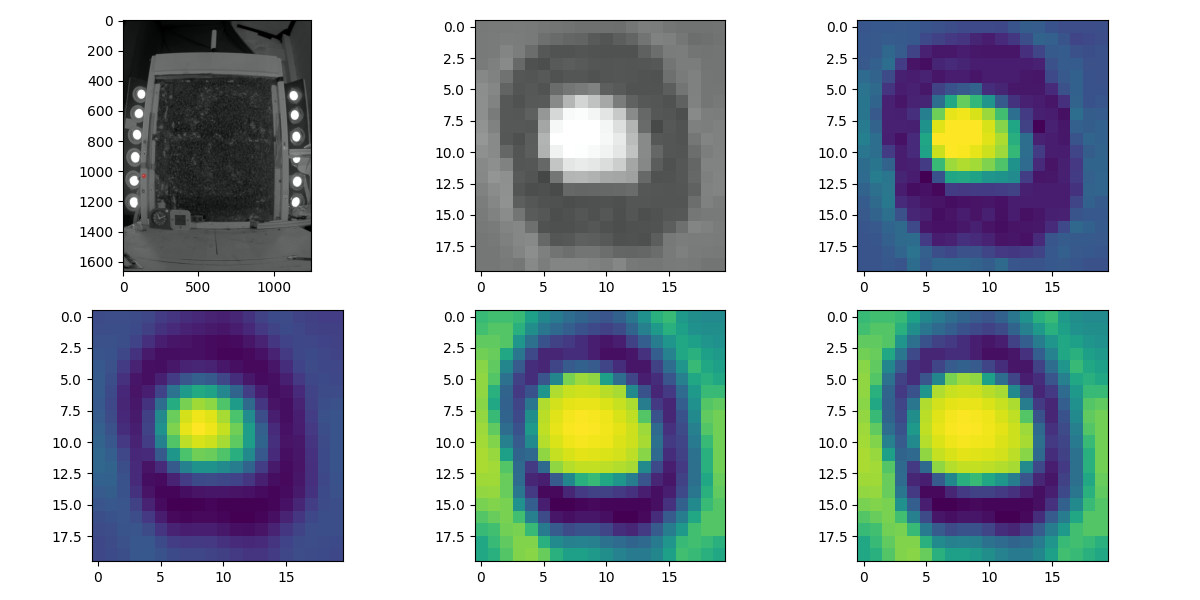

In [8]:
LED_CROPS = {
    '0' : {'x' : [ 865, 885], 'y' : [130,150]},
    '1' : {'x' : [1020,1040], 'y' : [125,145]}
}

test_led = '1'
WV.show_video_frame_wdd(video=videos[rpi_of_interest], frame_of_interest=91, cropX=LED_CROPS[test_led]['x'], cropY=LED_CROPS[test_led]['y'])

In [9]:
if DATA_RECALCULATION_LEDS:
    leds_datapack = {}
    
    for key in LED_CROPS.keys():
        activities = WV.compute_video_intensity_wdd(videos[rpi_of_interest], frames='all', cropX=LED_CROPS[key]['x'], cropY=LED_CROPS[key]['y'])
        leds_datapack[key] = {}
        leds_datapack[key]['act'] = activities
        leds_datapack[key]['fname'] = videos[rpi_of_interest]
        leds_datapack[key]['crop'] = LED_CROPS[key]
        leds_datapack[key]['pos'] = key
    
    with open(spath + 'leds_intensities.json', 'wb') as fp:
        pickle.dump(leds_datapack, fp)
else :
    with open(spath + 'leds_intensities.json', 'rb') as fp:
        leds_datapack = pickle.load(fp)

#### Theoritical LED intensities from output file

In [10]:
def extract_signal_from_what(what, FPS=30):
    try :
        what = what.replace(' ', '')
        what = what.replace(')', '')
        params = what.split('(')[-1].split(',')
        trig0 = [par.split('=')[-1] for par in params if par.startswith('file_index0')][0]
        trig1 = [par.split('=')[-1] for par in params if par.startswith('file_index1')][0]
        dur = float([par.split('=')[-1] for par in params if par.startswith('duration')][0])

        if trig0 == 'None':
            trig0 = 11
        else:
            trig0 = int(trig0)
        if trig1 == 'None':
            trig1 = 11
        else:
            trig1 = int(trig1)
    except:
        trig0 = None
        trig1 = None
        print('could not read params')

    signal0 = [trig0]*round(dur*FPS)
    signal1 = [trig1]*round(dur*FPS)

    delay_sb = 0.450
    delay_sb_frames = round(delay_sb*FPS)

    signal0 = [11]*delay_sb_frames+signal0[:-delay_sb_frames]
    signal1 = [11]*delay_sb_frames+signal1[:-delay_sb_frames]
    
    return signal0, signal1, dur

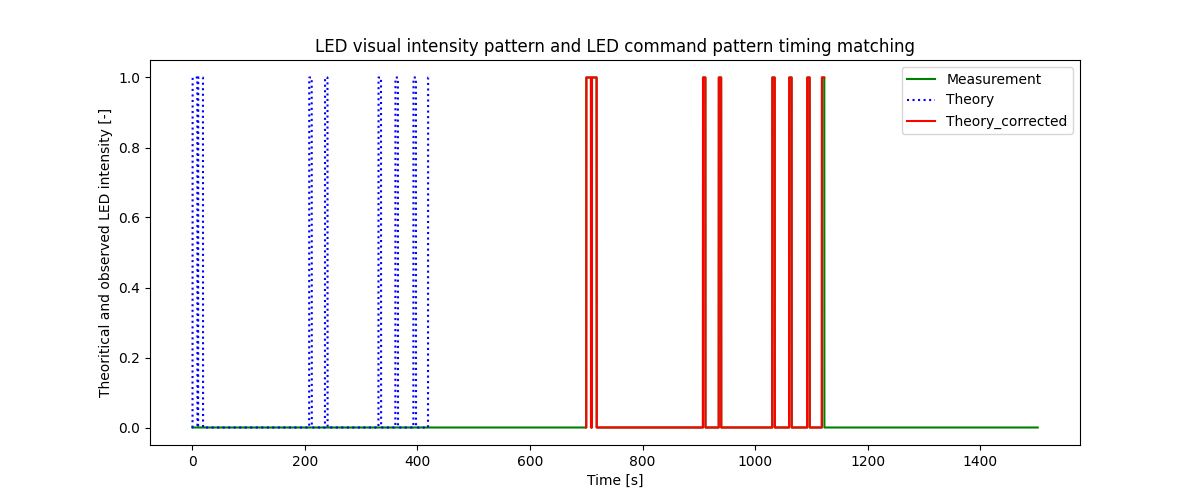

In [11]:
serial_port_used_notification = "sending comb message"
serial_mask = (bridge_output['message']==serial_port_used_notification)
serial_bridge_output = bridge_output.loc[serial_mask]

signal_trig0 = {'value':[]}
signal_trig1 = {'value':[]}

# signal_trig0 = {'value':[11]}
# signal_trig1 = {'value':[11]}

min_time = serial_bridge_output.iloc[0].UTC_timestamp
prev_time = min_time
for row_id, row in serial_bridge_output.iterrows():
    s0, s1, last_sig_duration = extract_signal_from_what(row.what, FPS=N_FPS)
    prior_elapsed_time_seconds = (row.UTC_timestamp-prev_time).total_seconds()
    if prior_elapsed_time_seconds > 0:
        signal_trig0['value'] = signal_trig0['value'] + [11]*round(prior_elapsed_time_seconds*N_FPS)
        signal_trig1['value'] = signal_trig1['value'] + [11]*round(prior_elapsed_time_seconds*N_FPS)

        signal_trig0['value'] = signal_trig0['value'] + s0
        signal_trig1['value'] = signal_trig1['value'] + s1
    else :
        signal_trig0['value'] = signal_trig0['value'] + s0[round(-prior_elapsed_time_seconds*N_FPS):]
        signal_trig1['value'] = signal_trig1['value'] + s1[round(-prior_elapsed_time_seconds*N_FPS):]
    prev_time = row.UTC_timestamp + datetime.timedelta(seconds=last_sig_duration)

# signal_trig0['value'] = signal_trig0['value'] + [11]
# signal_trig1['value'] = signal_trig1['value'] + [11]

time_vector = [min_time + datetime.timedelta(seconds=tstamp/N_FPS) for tstamp in range(len(signal_trig0['value']))]

# matplotlib.pyplot.figure()
# matplotlib.pyplot.plot(time_vector, signal_trig0['value'], 'r')
# matplotlib.pyplot.plot(time_vector, signal_trig1['value'], 'g')

frame_shift = WV.compute_time_shift_wdd(leds_datapack['1']['act'], signal_trig1['value'], save_plot_fname=gpath+'led'+'1'+'_pattern_matching.png')
time_shift = frame_shift*1/N_FPS

signal_trig0['frames'] = range(len(leds_datapack['0']['act']))
signal_trig0['value'] = [11]*frame_shift + signal_trig0['value'] + [11]*(len(signal_trig0['frames'])-frame_shift-len(signal_trig0['value']))
signal_trig0['times'] = [min_time + datetime.timedelta(seconds=numpy.float64(t-frame_shift)) for t in signal_trig0['frames']]

signal_trig1['frames'] = range(len(leds_datapack['1']['act']))
signal_trig1['value'] = [11]*frame_shift + signal_trig1['value'] + [11]*(len(signal_trig1['frames'])-frame_shift-len(signal_trig1['value']))
signal_trig1['times'] = [min_time + datetime.timedelta(seconds=numpy.float64(t-frame_shift)) for t in signal_trig1['frames']]

# matplotlib.pyplot. 

# matplotlib.pyplot.figure()
# matplotlib.pyplot.plot(signal_trig0['times'], signal_trig0['value'], 'r')
# matplotlib.pyplot.plot(signal_trig1['frames'], signal_trig1['value'], 'g')

In [12]:
# Waggles positions
homography1_values = camera_parameters['cameras'][0]['homography']
homography1, _ = cv2.findHomography(numpy.array(homography1_values["pixels"]).reshape(4, 2), numpy.array(homography1_values["units"]).reshape(4, 2))

homography2_values = physical_parameters['cameras'][0]['homography']
homography2, _ = cv2.findHomography(numpy.array(homography2_values["units"]).reshape(4, 2), numpy.array(homography2_values["pixels"]).reshape(4, 2))

for row_id, row in waggles_df.iterrows():
    xy = cv2.perspectiveTransform(numpy.array([[row.wdd_x, row.wdd_y]]).reshape(-1, 1, 2), homography1)
    ij = cv2.perspectiveTransform(numpy.array((xy[0])).reshape(-1, 1, 2), homography2)
    # print(ij)
    row['wdd_i'] = int(ij[0][0][0])
    row['wdd_j'] = int(ij[0][0][1])
    waggles_df.loc[row_id] = row


# Waggles times correction
print(time_shift)
for row_id, row in waggles_df.iterrows():
    row['start_frame'] = int((row['timestamp_begin']-min_time).total_seconds()*N_FPS + frame_shift)
    row['stop_frame'] = int((row['timestamp_end']-min_time).total_seconds()*N_FPS + frame_shift)
    waggles_df.loc[row_id] = row
waggles_df

699.6


,waggle_id,waggle_angle,waggle_duration,wdd_x,wdd_y,timestamp_begin,timestamp_end,wdd_i,wdd_j,start_frame,stop_frame
0,1.820882e+19,-2.666577,1.174791,1733.000000,720.000000,2023-06-21 09:34:42.442203+00:00,2023-06-21 09:34:42.775564+00:00,949,1055,44017,44027
1,1.422468e+19,-2.035801,1.103077,1173.000000,856.000000,2023-06-21 09:34:38.525362+00:00,2023-06-21 09:34:38.808664+00:00,674,1115,43899,43908
2,1.534038e+19,-1.205283,1.008350,1294.588015,692.164794,2023-06-21 09:34:27.541462+00:00,2023-06-21 09:34:27.974797+00:00,736,1038,43570,43583
3,1.348913e+19,-0.408424,0.650568,1581.000000,808.000000,2023-06-21 09:34:25.974597+00:00,2023-06-21 09:34:26.374584+00:00,874,1095,43523,43535
4,1.368243e+19,1.889858,0.724298,1321.465116,629.932817,2023-06-21 09:34:22.107731+00:00,2023-06-21 09:34:22.557747+00:00,750,1009,43407,43420
...,...,...,...,...,...,...,...,...,...,...,...
266,1.074199e+19,2.761237,1.367665,1781.000000,712.000000,2023-06-21 09:10:15.426073+00:00,2023-06-21 09:10:15.859376+00:00,972,1051,6,19
267,1.597205e+19,-2.801924,0.732652,1661.000000,808.000000,2023-06-21 09:10:12.725926+00:00,2023-06-21 09:10:13.626039+00:00,913,1095,-74,-47
268,1.564074e+19,2.981874,0.912114,1661.000000,800.000000,2023-06-21 09:10:10.942497+00:00,2023-06-21 09:10:11.725771+00:00,913,1092,-127,-104
269,1.478213e+19,-2.718698,0.668425,1669.000000,776.000000,2023-06-21 09:10:08.109000+00:00,2023-06-21 09:10:08.308878+00:00,917,1080,-212,-206


In [13]:
print(min_time)

2023-06-21 09:21:54.805130+00:00


In [14]:
def annotate_video(video, cropX=None, cropY=None, frames='all', rotate=True, video_save=True, video_filename=None, video_foldername=None, trig0=[], trig1=[], led_crops={}, fps=30, waggles=None):
    
    if (video_filename in os.listdir(video_foldername)):
        os.system('rm {}'.format(video_foldername+video_filename))

    height, width = [0,0]
    video_handler = []
    

    cap = cv2.VideoCapture(video)
        
    if frames=='all':
        stop_frame=2000000000
    else :
        stop_frame=frames
        
    frame_count = 0
    print('')
    while(cap.isOpened()):
        ret, frame = cap.read()
        frame_count += 1
        if ret == False or frame_count > stop_frame:
            print('')
            break
        
        if rotate:
            frame = cv2.rotate(frame, rotateCode=cv2.ROTATE_90_CLOCKWISE)
        if not(cropX is None):
            frame_crop = frame[cropX[0]:cropX[1],:]
        else:
            frame_crop=frame
        if not(cropY is None):
            frame_crop = frame_crop[:,cropY[0]:cropY[1]]
        

        if frame_count == 1:
            height, width = frame_crop.shape[:2]
            video_handler = cv2.VideoWriter(video_foldername+video_filename, cv2.VideoWriter_fourcc('m','p','4','v'), fps, (width,height))

        print('\r'+str(frame_count) + ' frames processed     ', sep=' ', end='', flush=True)

        frame_to_write = frame_crop
        # Actuation visu 
        try:
            if not(trig0==[]):
                if not(trig0[frame_count-1]==11):
                    cv2.rectangle(frame_to_write,(led_crops['0']['y'][0],led_crops['0']['x'][0]),(led_crops['0']['y'][1],led_crops['0']['x'][1]),(0,255,0),3)
            
            if not(trig1==[]):
                if not(trig1[frame_count-1]==11):
                    cv2.rectangle(frame_to_write,(led_crops['1']['y'][0],led_crops['1']['x'][0]),(led_crops['1']['y'][1],led_crops['1']['x'][1]),(0,255,0),3)
        except:
            pass

        # Waggle runs visu
        try:
            current_waggles_mask = (waggles['start_frame']<=frame_count-1)&(waggles['stop_frame']>=frame_count-1)
            current_waggles = waggles.loc[current_waggles_mask]
            for row_id, row in current_waggles.iterrows():
                cv2.circle(frame_to_write, (row.wdd_i, row.wdd_j), radius=50, color=(255,0,0), thickness=3)
        except:
            pass

        if video_save :
            # print(video_handler)
            video_handler.write(numpy.uint8(frame_to_write[:,:,[2,1,0]]))

    if video_save:
        cv2.destroyAllWindows()
        video_handler.release()
        del video_handler
    print('Overall number of frames : {}'.format(frame_count))
    

In [15]:
annotate_video(
    videos[rpi_of_interest], 
    frames=FRAMES_TO_PROCESS,#'all', 
    rotate=True, 
    video_save=True, 
    video_filename='test.mp4', 
    video_foldername=vpath, 
    trig0=signal_trig0['value'], 
    trig1=signal_trig1['value'], 
    led_crops=LED_CROPS,
    waggles=waggles_df
)


1000 frames processed     
Overall number of frames : 1001


In [16]:
actuation_zones = scipy.ndimage.measurements.label(numpy.maximum(numpy.logical_not(theory_l0).astype(numpy.uint8), numpy.logical_not(theory_l1).astype(numpy.uint8)))

print('--> {} actuation zones found.'.format(actuation_zones[1]))

amp_config = ACM.extract_amp_config(exp_folder+FOLDER_AMP2+FILENAME_AMP2)
signals_config = SCM.extract_signals_config(exp_folder+FOLDER_SIGNALS+FILENAME_SIGNALS)

actuation_pattern = AM.create_actuation_pattern(theory_trig0, theory_trig1, amp_config, signals_config, save_plot_fname=gpath+available_times[time_of_interest]+'_actuation_pattern.png')
actuation_pattern['times'] = theory_trigs['times']


NameError: name 'theory_l0' is not defined

In [ ]:
print(times_camera)

[0.0, 0.03331, 0.06662399999999999, 0.09993300000000001, 0.133244, 0.166555, 0.199867, 0.233179, 0.266489, 0.2998, 0.333111, 0.366422, 0.399735, 0.433045, 0.466356, 0.499668, 0.532978, 0.5662910000000001, 0.599601, 0.6329130000000001, 0.6662250000000001, 0.699535, 0.732846, 0.7661570000000001, 0.799468, 0.832779, 0.866091, 0.899401, 0.932713, 0.966025, 0.9993350000000001, 1.0326469999999999, 1.0659580000000002, 1.099269, 1.13258, 1.165891, 1.199203, 1.2325139999999999, 1.265825, 1.299136, 1.332447, 1.365759, 1.399069, 1.4323800000000002, 1.465691, 1.4990029999999999, 1.532313, 1.565626, 1.598936, 1.6322480000000001, 1.665559, 1.698871, 1.732181, 1.765492, 1.7988030000000002, 1.832115, 1.865427, 1.898739, 1.932048, 1.9653589999999999, 1.998671, 2.031982, 2.065293, 2.098603, 2.131915, 2.165227, 2.198537, 2.231849, 2.26516, 2.2984720000000003, 2.331782, 2.365094, 2.398404, 2.4317159999999998, 2.465027, 2.498339, 2.53165, 2.564961, 2.598271, 2.6315839999999997, 2.664894, 2.6982060000000003